In [20]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import sys
sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [21]:
neon = gpd.read_file("/projects/old_shared/fire_weather_vis/ref_data/NEON_DOMAIN/NEON_Domains.shp")


In [3]:
### Get all IDs

# flist = os.listdir("/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/") ### why is this changing every time? 


# import re

# file_ids = [re.sub("([^a-zA-Z0-9].*)$", "", x) for x in flist]
# file_ids = [re.sub("F", "", x) for x in file_ids]

# ids = file_ids
# file_ids = set(file_ids)

In [6]:
#list(file_ids)[0]

In [187]:
#i = list(file_ids)[0]

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map)
st_dict = stations[['Lat', 'Lon']].to_dict('records')

i = '11446'

year = "2020"

region = "WesternUS_REDO"

In [242]:
def station_spread(st_id_map, st_dict, files, i, year, region):

    try:
        raw_fire = fv.load_large_fire(i, year = year, path_region= region)
        raw_fire["fireID"] = str(i)
        if (len(raw_fire) == 0):
            return(None)
        full = fv.get_gpm_spread(raw_fire)
        
        ## Chop off at area asymptote. 5 consectutive days where area hasn't moved. 
        asymptote = min(full[full.farea_diff.rolling(5).sum() == 0].t)
        full = full[full.t < asymptote ]
    except Exception as e:
        print("Error at imerge_merge with Fire: ",i,)
        return(None)
#         bad_log = traceback.format_exc(limit = 40) # Get log of error
#         print(bad_log)
#         bad_ids.append(
#         {
#             "fireID": i, 
#             "func_failed": "imerge_merge",
#             "log": bad_log
#         }
#         )

    ### Find the closest station

    foi = full
    foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
    foi = foi.iloc[0] # First element

    stations = fv.st_avail(files, st_id_map = st_id_map)
    #stations = fv.closest_srch(st_dict, foi)
    all_st_search = fv.all_stations_search(st_dict = st_dict, fire_center = foi, id_key = st_id_map)

    final_perimeter = full[full.t == max(full.t)]
    #print(final_perimeter.envelope.exterior.coords.xy)
    #lons = final_perimeter.envelope.exterior.coords.xy[0]
    #lats = final_perimeter.envelope.exterior.coords.xy[1]


    ### Find the neon region the fire is in. 

    regions = gpd.overlay(neon, final_perimeter, how = "intersection")
    regions = neon[neon.DomainID.isin(regions.DomainID)]
    #print(regions)

    ## get subset of stations that are close to the fire

    sub_search = all_st_search[all_st_search.Dist_to_fire < 150]
    sub_search = gpd.GeoDataFrame(sub_search, geometry=gpd.points_from_xy(sub_search.Lon, sub_search.Lat))

    if(len(sub_search) > 0):
        ## Check if in any of the intersecting regions
        sts = gpd.overlay(sub_search.set_crs("epsg:4326"), regions.to_crs("epsg:4326"), how = 'intersection')
        fire_min = min(full.t)
        fire_max = max(full.t)

        ### Check if overlapping time range
        sts.BEGIN = pd.to_datetime(sts['BEGIN'], format='%Y%m%d')
        sts.END = pd.to_datetime(sts['END'], format='%Y%m%d')

        sts = sts[sts.END >= fire_max]
        sts = sts[sts.BEGIN <= fire_min]
        #print(sts)
        if(len(sts) > 0):
            ## Optionally merge
            sts = sts[sts.Dist_to_fire == min(sts.Dist_to_fire)] ## Get closest station
            #st = fv.get_st(lat = sts.Lat, lon = sts.Lon, stations = stations)
            #print(sts)
            st = stations.loc[(stations.Lat == sts.Lat[0]) & (stations.Lon == sts.Lon[0])]
            dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
            dat = fv.date_convert(dat)
            full['st_ID'] = str(sts.USAF[0]) + "_" + str(sts.WBAN[0])
            full['st_dist_to_fire'] = str(sts.Dist_to_fire.unique())
            full_m = fv.fr_st_merge(full, dat,  sub_type = "month_before")
            #full_m = fv.fr_st_merge(full, dat)
            full_m["fireID"] = str(full_m.fireID[0])
            return(full_m)

        ## Optionally write out a cheat-sheet
        
        
# def station_spread2(st_id_map, st_dict, files, i, year, region):


#     full = fv.load_large_fire(i, year = year, path_region= region)
#     full["fireID"] = str(i)


#     ### Find the closest station

#     foi = full
#     foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
#     foi = foi.iloc[0] # First element

#     stations = fv.st_avail(files, st_id_map = st_id_map)
#     #stations = fv.closest_srch(st_dict, foi)
#     all_st_search = fv.all_stations_search(st_dict = st_dict, fire_center = foi, id_key = st_id_map)

#     final_perimeter = full[full.t == max(full.t)]
#     #print(final_perimeter.envelope.exterior.coords.xy)
#     #lons = final_perimeter.envelope.exterior.coords.xy[0]
#     #lats = final_perimeter.envelope.exterior.coords.xy[1]


#     ### Find the neon region the fire is in. 

#     regions = gpd.overlay(neon, final_perimeter, how = "intersection")
#     regions = neon[neon.DomainID.isin(regions.DomainID)]
#     #print(regions)

#     ## get subset of stations that are close to the fire

#     sub_search = all_st_search[all_st_search.Dist_to_fire < 150]
#     sub_search = gpd.GeoDataFrame(sub_search, geometry=gpd.points_from_xy(sub_search.Lon, sub_search.Lat))

#     if(len(sub_search) > 0):
#         ## Check if in any of the intersecting regions
#         sts = gpd.overlay(sub_search.set_crs("epsg:4326"), regions.to_crs("epsg:4326"), how = 'intersection')
#         fire_min = min(full.t)
#         fire_max = max(full.t)

#         ### Check if overlapping time range
#         sts.BEGIN = pd.to_datetime(sts['BEGIN'], format='%Y%m%d')
#         sts.END = pd.to_datetime(sts['END'], format='%Y%m%d')

#         sts = sts[sts.END >= fire_max]
#         sts = sts[sts.BEGIN <= fire_min]
#         #print(sts)
#         if(len(sts) > 0):
#             ## Optionally merge
#             sts = sts[sts.Dist_to_fire == min(sts.Dist_to_fire)] ## Get closest station
#             #st = fv.get_st(lat = sts.Lat, lon = sts.Lon, stations = stations)
#             print(sts)
#             st = stations.loc[(stations.Lat == sts.Lat[0]) & (stations.Lon == sts.Lon[0])]
#             dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
#             dat = fv.date_convert(dat)
#             full['st_ID'] = str(sts.USAF[0]) + "_" + str(sts.WBAN[0])
#             full['st_dist_to_fire'] = str(sts.Dist_to_fire.unique())
#             full_m = fv.fr_st_merge(full, dat,  sub_type = "month_before")
#             full_m["fireID"] = str(full_m.fireID[0])
    
#             total = fv.get_gpm_spread(full_m)
#             return(total)

#         ## Optionally write out a cheat-sheet

In [188]:
def get_spread_period(full_fr, time_of_interest = 12,  hours_before = 0, lags = [-2,-4,-12,-24,-48]):
    
    lables = ["Night", "Day"]
    for i in lables:
        
        times_ig = full_fr["t"].loc[full_fr["spread_line" + i] == 2]
        times = full_fr["t"].loc[full_fr["spread_line" + i] == True] ## Is this acurate given the definitions above? 
        times_not = full_fr["t"].loc[full_fr["spread_line" + i] == False]
        #times_not = times_not[(times_not.dt.hour == 13) & (times_not.dt.minute == 30)]

        full_fr["spread_period"+ i] = np.nan
        full_fr["spread_period"+ i + "_igs"] = np.nan
    
        
        for t in times_ig:
            times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
            times_end = t - np.timedelta64((hours_before), "h")
            full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS

        for t in times:
            times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
            times_end = t - np.timedelta64((hours_before), "h")
            full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True


        for l in times_not:
            times_start = l - np.timedelta64((time_of_interest + hours_before), "h")
            times_end = l - np.timedelta64((hours_before), "h")
            full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = False

        for lag in lags:
            full_fr["spread_period"+ i +"_lag_" + str(lag)] = full_fr["spread_period"+ i].shift(lag)

    return(full_fr)

In [189]:
files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map)
st_dict = stations[['Lat', 'Lon']].to_dict('records')

#i = '11446'
i = '11440'

year = "2020"

region = "WesternUS_REDO"


full = station_spread(st_id_map = st_id_map, st_dict = st_dict, files = files, i = i, year = year, region = region)
full = get_spread_period(full)

#full

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/4253638639.py:80: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

In [198]:
full.farea_diff

148     NaN
149     NaN
150     NaN
151     NaN
152     NaN
153     NaN
154     NaN
155     NaN
156     NaN
157     NaN
158     NaN
159     NaN
160     NaN
161     NaN
162     NaN
163     NaN
164     NaN
165     NaN
166     NaN
167     NaN
168     NaN
169     NaN
170     NaN
171     NaN
172     NaN
173     NaN
174     NaN
175     NaN
176     NaN
177     NaN
       ... 
2468    NaN
2469    NaN
2470    NaN
2471    NaN
2472    NaN
145     0.0
2473    NaN
2474    NaN
2475    NaN
2476    NaN
2477    NaN
2478    NaN
2479    NaN
2480    NaN
2481    NaN
2482    NaN
2483    NaN
146     0.0
2484    NaN
2485    NaN
2486    NaN
2487    NaN
2488    NaN
2489    NaN
2490    NaN
2491    NaN
2492    NaN
2493    NaN
2494    NaN
147     0.0
Name: farea_diff, Length: 2495, dtype: float64

In [197]:
full = full.sort_values(by = ["t"])
pd.set_option('display.min_rows', 5000)
#pd.reset_option('display.max_rows')
sub = full[full.t > "2020-08-16 00:00:00"]
sub[["fireID", "t", "farea", "FWI", "spread_lineDay", "spread_lineNight", "spread_periodDay","spread_periodNight", "spread_periodDay_igs", "spread_periodNight_igs"]].head(500)


fireID                   t       farea     FWI spread_lineDay  \
855   11440 2020-08-16 01:00:00         NaN  33.555            NaN   
856   11440 2020-08-16 02:00:00         NaN  25.618            NaN   
857   11440 2020-08-16 03:00:00         NaN  31.430            NaN   
858   11440 2020-08-16 04:00:00         NaN  23.487            NaN   
859   11440 2020-08-16 05:00:00         NaN  22.676            NaN   
860   11440 2020-08-16 06:00:00         NaN  21.888            NaN   
861   11440 2020-08-16 07:00:00         NaN  21.816            NaN   
862   11440 2020-08-16 08:00:00         NaN  21.798            NaN   
863   11440 2020-08-16 09:00:00         NaN  22.563            NaN   
864   11440 2020-08-16 10:00:00         NaN  28.177            NaN   
865   11440 2020-08-16 11:00:00         NaN  32.366            NaN   
866   11440 2020-08-16 12:00:00         NaN  26.273            NaN   
867   11440 2020-08-16 13:00:00         NaN  28.138            NaN   
868   11440 2020-08-16 14:00:00         NaN  50.780            NaN   
869   11440 2020-08-16 15:00:00         NaN  37.478            NaN   
870   11440 2020-08-16 16:00:00         NaN  42.640            NaN   
871   11440 2020-08-16 17:00:00         NaN  34.900            NaN   
872   11440 2020-08-16 18:00:00         NaN  27.948            NaN   
873   11440 2020-08-16 19:00:00         NaN  35.707            NaN   
874   11440 2020-08-16 20:00:00         NaN  26.850            NaN   
875   11440 2020-08-16 21:00:00         NaN  30.761            NaN   
876   11440 2020-08-16 22:00:00         NaN  34.161            NaN   
877   11440 2020-08-16 23:00:00         NaN  30.934            NaN   
0     11440 2020-08-17 00:00:00    0.350845  23.630            NaN   
878   11440 2020-08-17 01:00:00         NaN  23.427            NaN   
879   11440 2020-08-17 02:00:00         NaN  28.564            NaN   
880   11440 2020-08-17 03:00:00         NaN  21.266            NaN   
881   11440 2020-08-17 04:00:00         NaN  20.721            NaN   
882   11440 2020-08-17 05:00:00         NaN  19.952            NaN   
883   11440 2020-08-17 06:00:00         NaN  19.508            NaN   
...     ...                 ...         ...     ...            ...   
1287  11440 2020-09-04 15:00:00         NaN  36.123            NaN   
1288  11440 2020-09-04 16:00:00         NaN  34.632            NaN   
1289  11440 2020-09-04 17:00:00         NaN  41.888            NaN   
1290  11440 2020-09-04 18:00:00         NaN  33.878            NaN   
1291  11440 2020-09-04 19:00:00         NaN  32.400            NaN   
1292  11440 2020-09-04 20:00:00         NaN  24.365            NaN   
1293  11440 2020-09-04 21:00:00         NaN  28.069            NaN   
1294  11440 2020-09-04 22:00:00         NaN  23.630            NaN   
1295  11440 2020-09-04 23:00:00         NaN  19.501            NaN   
38    11440 2020-09-05 00:00:00   89.885407  20.036            NaN   
1296  11440 2020-09-05 01:00:00         NaN  17.315            NaN   
1297  11440 2020-09-05 02:00:00         NaN  13.811            NaN   
1298  11440 2020-09-05 03:00:00         NaN  13.201            NaN   
1299  11440 2020-09-05 04:00:00         NaN  12.745            NaN   
1300  11440 2020-09-05 05:00:00         NaN  12.342            NaN   
1301  11440 2020-09-05 06:00:00         NaN  12.201            NaN   
1302  11440 2020-09-05 07:00:00         NaN  15.020            NaN   
1303  11440 2020-09-05 08:00:00         NaN  14.683            NaN   
1304  11440 2020-09-05 09:00:00         NaN  12.007            NaN   
1305  11440 2020-09-05 10:00:00         NaN  12.176            NaN   
1306  11440 2020-09-05 11:00:00         NaN  16.715            NaN   
39    11440 2020-09-05 12:00:00  120.730432  13.137           True   
1307  11440 2020-09-05 13:00:00         NaN  24.373            NaN   
1308  11440 2020-09-05 14:00:00         NaN  20.974            NaN   
1309  11440 2020-09-05 15:00:00         NaN  27.866            NaN   
1310  11440 202

(array([18489., 18506., 18520., 18536., 18550., 18567.]),
 [Text(18489.0, 0, '2020-08-15'),
  Text(18506.0, 0, '2020-09-01'),
  Text(18520.0, 0, '2020-09-15'),
  Text(18536.0, 0, '2020-10-01'),
  Text(18550.0, 0, '2020-10-15'),
  Text(18567.0, 0, '2020-11-01')])

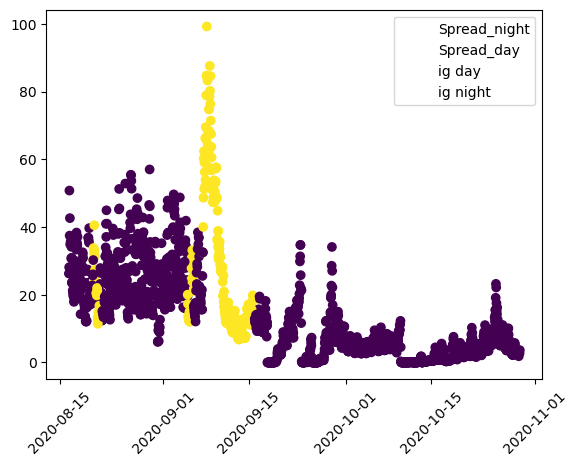

In [192]:


full = full.sort_values(by = ["t"])

plt.scatter(full.t.astype('datetime64[ns]'), full.FWI, c = full["spread_periodNight"], label = "Spread_night")
plt.scatter(full.t.astype('datetime64[ns]'), full.FWI, c = full["spread_periodDay"], label = "Spread_day")
plt.scatter(full.t.astype('datetime64[ns]'), full.FWI, c = full["spread_periodDay_igs"], label = "ig day")
plt.scatter(full.t.astype('datetime64[ns]'), full.FWI, c = full["spread_periodNight_igs"], label = "ig night")
plt.legend()
plt.xticks(rotation = 45)

# lags = [-2,-4,-12,-24,-48]

# for l in lags:
#     plt.scatter(full.t.astype('datetime64[ns]'), full.FWI, c = full["spread_periodNight" + "_lag_" + str(l)], label = "Spread_night")
#     plt.scatter(full.t.astype('datetime64[ns]'), full.FWI, c = full["spread_periodDay" + "_lag_" + str(l)], label = "Spread_day")
#     plt.title(str(l))
#     plt.legend()
#     plt.xticks(rotation = 45)
#     plt.show()

In [ ]:
full = full.sort_values(by = ["t"])

plt.scatter(full.t.astype('datetime64[ns]'), full.farea, c = full["spread_periodNight"], label = "Spread_night")
plt.scatter(full.t.astype('datetime64[ns]'), full.farea, c = full["spread_periodDay"], label = "Spread_day")
plt.legend()
plt.xticks(rotation = 45)

In [199]:
i = '11440'

year = "2020"

region = "WesternUS_REDO"

raw_fire = fv.load_large_fire(i, year = year, path_region= region)
raw_fire["fireID"] = str(i)
full = fv.get_gpm_spread(raw_fire)

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

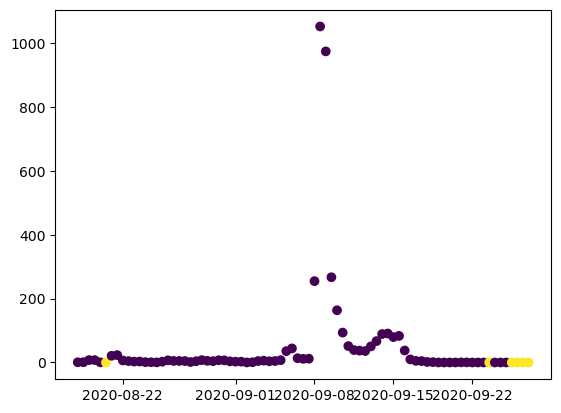

In [219]:
asymptote = min(full[full.farea_diff.rolling(5).sum() == 0].t)

sub = full[full.t < asymptote ]

plt.scatter(sub.t, sub.farea_diff, c = sub.farea_diff == 0)

In [218]:
min(full[full.farea_diff.rolling(5).sum() == 0].t)

Timestamp('2020-09-27 12:00:00')

In [223]:
### New horrible for loop 


flist = os.listdir("/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/")

In [232]:
import re

file_ids = [re.sub("([^a-zA-Z0-9].*)$", "", x) for x in flist]
file_ids = [re.sub("F", "", x) for x in file_ids]

file_ids = set(file_ids)

In [238]:
diff_ids = list(file_ids)
diff_ids
# Bad id 13096
sub_ids = diff_ids[21:(len(diff_ids) -1)] ## n = 21


In [244]:
### Put all together into horrible for-loop
small_ids = ["7656", '11440']
#small_ids = file_ids
#small_ids = ids.astype("str")
#small_ids = ids.astype("str")

import time
from datetime import date
import traceback

#import logging
#logging.basicConfig(level=logging.ERROR)
#logger = logging.getLogger(__name__)


# Grab Currrent Time Before Running the Code
start = time.time()

################# Horrible for loop ##################
sub_region = "all_west"
region =  "WesternUS_REDO"
year = "2020"

run_name = str(date.today()) + "station_spread"
allfr = [] # list of fire timeseries
bad_ids = [] # list of IDs that failed due to error

for n,i in enumerate(file_ids, start = 0):
        full = station_spread(st_id_map = st_id_map, st_dict = st_dict, files = files, i = i, year = year, region = region)
        if(full is None):
            continue
        else:
            fire = get_spread_period(full)
        
        allfr.append(fire)
        if((n%5 == 0) | (n == (len(small_ids) -1))):
            #print("")
            manyfr = gpd.GeoDataFrame(pd.concat(allfr, ignore_index=True), crs= fire.crs)
            manyfr.to_csv("/projects/old_shared//fire_spread/" + region + "_" + sub_region + "_" + year + "_" + run_name +".csv")
        
            debug = pd.DataFrame(bad_ids)
            debug.to_csv("/projects/old_shared/fire_spread/DEBUG_" + region + "_" + sub_region + "_" + year + "_" + run_name + ".csv") ## Need to generate custom path

# Grab Currrent Time After Running the Code
end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
print("\n"+ str(total_time))

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13997_20200926PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13997_20200927AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13997_20200927PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13997_20200928AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13997_20200928PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13997_20200929AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13997_20200929PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13997_20200930AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13997_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19669_20201210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19669_20201211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19669_20201211PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19669_20201212AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19669_20201212PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19669_20201213AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19669_20201213PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19669_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12513_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12513_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12513_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12513_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12513_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12513_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12513_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12513_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12513_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13201_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13201_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13201_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13201_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13201_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13201_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13201_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13201_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13201_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10719_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10719_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10719_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10719_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10719_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10719_20200806PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10719_20200807AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10719_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10719_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18034_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18034_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18034_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18034_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18034_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18034_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18034_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18034_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18034_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16125_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16125_20201104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16125_20201104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16125_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16125_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16125_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16125_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16125_20201107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16125_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15347_20201017PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15347_20201018AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15347_20201018PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15347_20201019AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15347_20201019PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15347_20201020AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15347_20201020PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15347_20201021AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15347_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11604_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11604_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11604_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11604_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11604_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11604_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11604_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11604_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17772_20201118PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17772_20201119AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17772_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17772_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17772_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17772_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17772_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17772_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F378_20200114AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F378_20200114PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F378_20200115AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F378_20200115PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F378_20200116AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F378_20200116PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F378_20200117AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F378_20200117PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F378_20200118AM', '/project

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7046_20200521PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7046_20200522AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7046_20200522PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7046_20200523AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7046_20200523PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7046_20200524AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7046_20200524PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7046_20200525AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7046_20200525PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9591_20200714AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9591_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9591_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9591_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9591_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9591_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9591_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9591_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9591_20200718AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19039_20201201PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19039_20201202AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19039_20201202PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19039_20201203AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19039_20201203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19039_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19039_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19039_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11398_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11398_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11398_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11398_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11398_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11398_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11398_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11398_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11398_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7672_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7672_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7672_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7672_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7672_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7672_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7672_20200612AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7672_20200612PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7672_20200613AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7850_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7850_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7850_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7850_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7850_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7850_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7850_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7850_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7850_20200612AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12076_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12076_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12076_20200826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12076_20200827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12076_20200827PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12076_20200828AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12076_20200828PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12076_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19125_20201202PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19125_20201203AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19125_20201203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19125_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19125_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19125_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19125_20201205PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19125_20201206AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19125_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3788_20200321PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3788_20200322AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3788_20200322PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3788_20200323AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3788_20200323PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3788_20200324AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3788_20200324PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3788_20200325AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3788_20200325PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11456_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11456_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11456_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11456_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11456_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11456_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11456_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11456_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11456_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13096_20200908PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  13096
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16504_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16504_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16504_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16504_20201104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16504_20201104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16504_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16504_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16504_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11633_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11633_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11633_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11633_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11633_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11633_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11633_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11633_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12811_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12811_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12811_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12811_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12811_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12811_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12811_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12811_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F173_20200108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F173_20200109AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F173_20200109PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F173_20200110AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F173_20200110PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F173_20200111AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F173_20200111PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F173_20200112AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F173_20200112PM', '/project

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10165_20200731PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10165_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10165_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10165_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10165_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10165_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10165_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10165_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10165_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11145_20200813PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11145_20200814AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11145_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11145_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11145_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11145_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11145_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11145_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11145_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8251_20200614AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8251_20200614PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8251_20200615AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8251_20200615PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8251_20200616AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8251_20200616PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8251_20200617AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8251_20200617P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16894_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16894_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16894_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16894_20201107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16894_20201107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16894_20201108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16894_20201108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16894_20201109AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16894_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15348_20201018AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15348_20201018PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15348_20201019AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15348_20201019PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15348_20201020AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15348_20201020PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15348_20201021AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15348_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18017_20201118AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18017_20201118PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18017_20201119AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18017_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18017_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18017_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18017_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18017_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18017_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9277_20200707PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9277_20200708AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9277_20200708PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9277_20200709AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9277_20200709PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9277_20200710AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9277_20200710PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9277_20200711AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9277_20200711PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16575_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16575_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16575_20201104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16575_20201104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16575_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16575_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16575_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16575_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16575_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11692_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11692_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11692_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11692_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11692_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11692_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11692_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11692_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11692_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  11692
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11546_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11546_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11546_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11546_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11546_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11546_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11546_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11546_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16031_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16031_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16031_20201101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16031_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16031_20201102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16031_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16031_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16031_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16031_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14349_20200930PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  14349
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11458_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11458_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11458_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11458_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11458_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11458_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11458_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11458_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18258_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18258_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18258_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18258_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18258_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18258_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18258_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18258_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18258_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4193_20200426AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4193_20200426PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4193_20200427AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4193_20200427PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4193_20200428AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4193_20200428PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4193_20200429AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4193_20200429PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4193_20200430AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9033_20200707PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9033_20200708AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9033_20200708PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9033_20200709AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9033_20200709PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9033_20200710AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9033_20200710PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9033_20200711A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10283_20200728AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10283_20200728PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10283_20200729AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10283_20200729PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10283_20200730AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10283_20200730PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10283_20200731AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10283_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6293_20200504AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6293_20200504PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6293_20200505AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6293_20200505PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6293_20200506AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6293_20200506PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6293_20200507AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6293_20200507P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7521_20200531AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7521_20200531PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7521_20200601AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7521_20200601PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7521_20200602AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7521_20200602PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7521_20200603AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7521_20200603PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7521_20200604AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11401_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11401_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11401_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11401_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11401_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11401_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11401_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11401_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11401_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11825_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11825_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11825_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11825_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11825_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11825_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11825_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11825_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11598_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11598_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11598_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11598_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11598_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11598_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11598_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11598_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11598_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13203_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13203_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13203_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13203_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13203_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13203_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13203_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13203_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  13203
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3773_20200326AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3773_20200326PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3773_20200327AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3773_20200327PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3773_20200328AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3773_20200328PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3773_20200329AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3773_20200329PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11310_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11310_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11310_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11310_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11310_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11310_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11310_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11310_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18109_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18109_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18109_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18109_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18109_20201123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18109_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18109_20201124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18109_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11531_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11531_20200818PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  11531
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11390_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11390_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11390_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11390_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11390_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11390_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11390_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11390_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14051_20200929AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14051_20200929PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14051_20200930AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14051_20200930PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14051_20201001AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14051_20201001PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14051_20201002AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14051_20201002PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14051_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17915_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17915_20201124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17915_20201125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17915_20201125PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17915_20201126AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17915_20201126PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17915_20201127AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17915_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19505_20201209AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19505_20201209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19505_20201210AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19505_20201210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19505_20201211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19505_20201211PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19505_20201212AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19505_20201212PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19505_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12960_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12960_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12960_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12960_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12960_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12960_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12960_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12960_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12960_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13273_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13273_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13273_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13273_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13273_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13273_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13273_20200913AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13273_20200913PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13273_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  13273
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18941_20201203AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18941_20201203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18941_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18941_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18941_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18941_20201205PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18941_20201206AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18941_20201206PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19446_20201210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19446_20201211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19446_20201211PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19446_20201212AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19446_20201212PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19446_20201213AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19446_20201213PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19446_20201214AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19446_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14047_20201005AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14047_20201005PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14047_20201006AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14047_20201006PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14047_20201007AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14047_20201007PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14047_20201008AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14047_20201008PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14047_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18334_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18334_20201124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18334_20201125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18334_20201125PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18334_20201126AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18334_20201126PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18334_20201127AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18334_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5836_20200503AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5836_20200503PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5836_20200504AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5836_20200504PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5836_20200505AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5836_20200505PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5836_20200506AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5836_20200506P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11632_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11632_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11632_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11632_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11632_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11632_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11632_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11632_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11632_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19293_20201203AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19293_20201203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19293_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19293_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19293_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19293_20201205PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19293_20201206AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19293_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19539_20201208PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19539_20201209AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19539_20201209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19539_20201210AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19539_20201210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19539_20201211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19539_20201211PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19539_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11656_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11656_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11656_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11656_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11656_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11656_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11656_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11656_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15991_20201105AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8842_20200628PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8842_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8842_20200629PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8842_20200630AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8842_20200630PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8842_20200701AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8842_20200701PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8842_20200702A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9314_20200708AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9314_20200708PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9314_20200709AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9314_20200709PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9314_20200710AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9314_20200710PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9314_20200711AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9314_20200711P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11811_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11811_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11811_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11811_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11811_20200826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11811_20200827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11811_20200827PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11811_20200828AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11811_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5861_20200426PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5861_20200427AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5861_20200427PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5861_20200428AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5861_20200428PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5861_20200429AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5861_20200429PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5861_20200430AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5861_20200430PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12949_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12949_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12949_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12949_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12949_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12949_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12949_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12949_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12949_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19178_20201203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19178_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19178_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19178_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19178_20201205PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19178_20201206AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19178_20201206PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19178_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10523_20200731PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10523_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10523_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10523_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10523_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10523_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10523_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10523_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10523_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8502_20200625PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8502_20200626AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8502_20200626PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8502_20200627AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8502_20200627PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8502_20200628AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8502_20200628PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8502_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8502_20200629PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13530_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13530_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13530_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13530_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13530_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13530_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13530_20200921AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13530_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19548_20201214AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19548_20201214PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19548_20201215AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19548_20201215PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19548_20201216AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19548_20201216PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19548_20201217AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19548_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3018_20200307AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3018_20200307PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3018_20200308AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3018_20200308PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3018_20200309AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3018_20200309PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3018_20200310AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3018_20200310P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F820_20200208AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F820_20200208PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F820_20200209AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F820_20200209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F820_20200210AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F820_20200210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F820_20200211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F820_20200211PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F820_20200212AM', '/project

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7977_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7977_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7977_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7977_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7977_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7977_20200612AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7977_20200612PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7977_20200613AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7977_20200613PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8318_20200619PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8318_20200620AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8318_20200620PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8318_20200621AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8318_20200621PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8318_20200622AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8318_20200622PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8318_20200623A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11696_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11696_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11696_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11696_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11696_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11696_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11696_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11696_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19264_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19264_20201205PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19264_20201206AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19264_20201206PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19264_20201207AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19264_20201207PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19264_20201208AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19264_20201208PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19264_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6911_20200516PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6911_20200517AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6911_20200517PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6911_20200518AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6911_20200518PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6911_20200519AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6911_20200519PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6911_20200520A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13505_20200914PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13505_20200915AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13505_20200915PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13505_20200916AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13505_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13505_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13505_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13505_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13505_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18141_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18141_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18141_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18141_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18141_20201123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18141_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18141_20201124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18141_20201125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18141_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7495_20200614AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7495_20200614PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7495_20200615AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7495_20200615PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7495_20200616AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7495_20200616PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7495_20200617AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7495_20200617PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7495_20200618AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13692_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13692_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13692_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13692_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13692_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13692_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13692_20200921AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13692_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9675_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9675_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9675_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9675_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9675_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9675_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9675_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9675_20200718P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10416_20200730AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10416_20200730PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10416_20200731AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10416_20200731PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10416_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10416_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10416_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10416_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10416_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8270_20200614PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8270_20200615AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8270_20200615PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8270_20200616AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8270_20200616PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8270_20200617AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8270_20200617PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8270_20200618A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9195_20200706AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9195_20200706PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9195_20200707AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9195_20200707PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9195_20200708AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9195_20200708PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9195_20200709AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9195_20200709PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9195_20200710AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15296_20201022PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15296_20201023AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15296_20201023PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15296_20201024AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15296_20201024PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15296_20201025AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15296_20201025PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15296_20201026AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15296_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10031_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10031_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10031_20200724AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10031_20200724PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10031_20200725AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10031_20200725PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10031_20200726AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10031_20200726PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10031_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12649_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12649_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12649_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12649_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12649_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12649_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12649_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12649_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12649_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10631_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10631_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10631_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10631_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10631_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10631_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10631_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10631_20200806PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10631_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13257_20200921AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13257_20200921PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13257_20200922AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13257_20200922PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13257_20200923AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13257_20200923PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13257_20200924AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13257_20200924PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13257_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F67_20200106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F67_20200106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F67_20200107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F67_20200107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F67_20200108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F67_20200108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F67_20200109AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F67_20200109PM', '/projects/s

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11386_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11386_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11386_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11386_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11386_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11386_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11386_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11386_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11386_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18381_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18381_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18381_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18381_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18381_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18381_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18381_20201123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18381_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12471_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12471_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12471_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12471_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12471_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12471_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12471_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12471_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16793_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16793_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16793_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16793_20201107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16793_20201107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16793_20201108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16793_20201108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16793_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5417_20200420AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5417_20200420PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5417_20200421AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5417_20200421PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5417_20200422AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5417_20200422PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5417_20200423AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5417_20200423PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5417_20200424AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12889_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12889_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12889_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12889_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12889_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12889_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12889_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12889_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12025_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12025_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12025_20200826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12025_20200827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12025_20200827PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12025_20200828AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12025_20200828PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12025_20200829AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12025_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12838_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12838_20200908AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  12838
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11921_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11921_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11921_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11921_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11921_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11921_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11921_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11921_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11247_20200814AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11247_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11247_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11247_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11247_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11247_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11247_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11247_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11247_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11693_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11693_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11693_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11693_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11693_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11693_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11693_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11693_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  11693
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9467_20200712PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9467_20200713AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9467_20200713PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9467_20200714AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9467_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9467_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9467_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9467_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20066_20201223AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20066_20201223PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20066_20201224AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20066_20201224PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20066_20201225AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20066_20201225PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20066_20201226AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20066_20201226PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20066_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16605_20201107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16605_20201108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16605_20201108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16605_20201109AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16605_20201109PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16605_20201110AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16605_20201110PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16605_20201111AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16605_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16261_20201104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16261_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16261_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16261_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16261_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16261_20201107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16261_20201107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16261_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19289_20201203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19289_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19289_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19289_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19289_20201205PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19289_20201206AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19289_20201206PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19289_20201207AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19289_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10391_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10391_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10391_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10391_20200806PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10391_20200807AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10391_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10391_20200808AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10391_20200808PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10391_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7811_20200607PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7811_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7811_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7811_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7811_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7811_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7811_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7811_20200611A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14278_20201001PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14278_20201002AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14278_20201002PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14278_20201003AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14278_20201003PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14278_20201004AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14278_20201004PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14278_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8859_20200701AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8859_20200701PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8859_20200702AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8859_20200702PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8859_20200703AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8859_20200703PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8859_20200704AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8859_20200704P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20175_20201221PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20175_20201222AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20175_20201222PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20175_20201223AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20175_20201223PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20175_20201224AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20175_20201224PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20175_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12470_20200902PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12470_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12470_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12470_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12470_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12470_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12470_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12470_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12470_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10096_20200724PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10096_20200725AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10096_20200725PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10096_20200726AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10096_20200726PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10096_20200727AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10096_20200727PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10096_20200728AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10096_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8376_20200617PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8376_20200618AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8376_20200618PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8376_20200619AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8376_20200619PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8376_20200620AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8376_20200620PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8376_20200621A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12391_20200901AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12391_20200901PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12391_20200902AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12391_20200902PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12391_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12391_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12391_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12391_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12391_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11395_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11395_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11395_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11395_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11395_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11395_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11395_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11395_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11395_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7896_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7896_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7896_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7896_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7896_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7896_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7896_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7896_20200612AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7896_20200612PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14058_20201008AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14058_20201008PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14058_20201009AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14058_20201009PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14058_20201010AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14058_20201010PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14058_20201011AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14058_20201011PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14058_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17672_20201117AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17672_20201117PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17672_20201118AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17672_20201118PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17672_20201119AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17672_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17672_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17672_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5555_20200425PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5555_20200426AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5555_20200426PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5555_20200427AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5555_20200427PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5555_20200428AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5555_20200428PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5555_20200429AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5555_20200429PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17936_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17936_20201124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17936_20201125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17936_20201125PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17936_20201126AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17936_20201126PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17936_20201127AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17936_20201127PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17936_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14951_20201010PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14951_20201011AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14951_20201011PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14951_20201012AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14951_20201012PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14951_20201013AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14951_20201013PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14951_20201014AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14951_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3485_20200313AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3485_20200313PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3485_20200314AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3485_20200314PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3485_20200315AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3485_20200315PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3485_20200316AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3485_20200316PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3485_20200317AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11161_20200811PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11161_20200812AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11161_20200812PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11161_20200813AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11161_20200813PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11161_20200814AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11161_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11161_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11161_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8746_20200626AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8746_20200626PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8746_20200627AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8746_20200627PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8746_20200628AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8746_20200628PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8746_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8746_20200629P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12120_20200828AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12120_20200828PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12120_20200829AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12120_20200829PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12120_20200830AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12120_20200830PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12120_20200831AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12120_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12955_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12955_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12955_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12955_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12955_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12955_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12955_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12955_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12955_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15118_20201015AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15118_20201015PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15118_20201016AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15118_20201016PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15118_20201017AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15118_20201017PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15118_20201018AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15118_20201018PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15118_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18619_20201202PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18619_20201203AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18619_20201203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18619_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18619_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18619_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18619_20201205PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18619_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14610_20201009AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14610_20201009PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14610_20201010AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14610_20201010PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14610_20201011AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14610_20201011PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14610_20201012AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14610_20201012PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14610_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10901_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10901_20200808AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10901_20200808PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10901_20200809AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10901_20200809PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10901_20200810AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10901_20200810PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10901_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12089_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12089_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12089_20200826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12089_20200827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12089_20200827PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12089_20200828AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12089_20200828PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12089_20200829AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12089_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11524_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11524_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11524_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11524_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11524_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11524_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11524_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11524_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11524_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8225_20200613PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8225_20200614AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8225_20200614PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8225_20200615AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8225_20200615PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8225_20200616AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8225_20200616PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8225_20200617AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8225_20200617PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11567_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11567_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11567_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11567_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11567_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11567_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11567_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11567_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12953_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12953_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12953_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12953_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12953_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12953_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12953_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12953_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13532_20200915AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13532_20200915PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13532_20200916AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13532_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13532_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13532_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13532_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13532_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13532_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17665_20201112PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17665_20201113AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17665_20201113PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17665_20201114AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17665_20201114PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17665_20201115AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17665_20201115PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17665_20201116AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17665_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7891_20200617AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7891_20200617PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7891_20200618AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7891_20200618PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7891_20200619AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7891_20200619PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7891_20200620AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7891_20200620PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7891_20200621AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20084_20201226PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20084_20201227AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20084_20201227PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20084_20201228AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20084_20201228PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20084_20201229AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20084_20201229PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20084_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6270_20200502PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6270_20200503AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6270_20200503PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6270_20200504AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6270_20200504PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6270_20200505AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6270_20200505PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6270_20200506AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6270_20200506PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7780_20200607PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7780_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7780_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7780_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7780_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7780_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7780_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7780_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7780_20200611PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11905_20200827PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11905_20200828AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11905_20200828PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11905_20200829AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11905_20200829PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11905_20200830AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11905_20200830PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11905_20200831AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11905_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15919_20201027PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15919_20201028AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15919_20201028PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15919_20201029AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15919_20201029PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15919_20201030AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15919_20201030PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15919_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15919_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14128_20200927PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14128_20200928AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14128_20200928PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14128_20200929AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14128_20200929PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14128_20200930AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14128_20200930PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14128_20201001AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14128_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8837_20200628AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8837_20200628PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8837_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8837_20200629PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8837_20200630AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8837_20200630PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8837_20200701AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8837_20200701PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8837_20200702AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7372_20200601AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7372_20200601PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7372_20200602AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7372_20200602PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7372_20200603AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7372_20200603PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7372_20200604AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7372_20200604PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7372_20200605AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1026_20200209AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1026_20200209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1026_20200210AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1026_20200210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1026_20200211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1026_20200211PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1026_20200212AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1026_20200212P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10750_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10750_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10750_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10750_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10750_20200806PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10750_20200807AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10750_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10750_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13069_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13069_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13069_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13069_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13069_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13069_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13069_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13069_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13069_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17973_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17973_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17973_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17973_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17973_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17973_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17973_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17973_20201123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17973_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7976_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7976_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7976_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7976_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7976_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7976_20200612AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7976_20200612PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7976_20200613AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7976_20200613PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19549_20201208AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19549_20201208PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19549_20201209AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19549_20201209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19549_20201210AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19549_20201210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19549_20201211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19549_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14203_20200928PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14203_20200929AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14203_20200929PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14203_20200930AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14203_20200930PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14203_20201001AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14203_20201001PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14203_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13054_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13054_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13054_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13054_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13054_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13054_20200912PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  13054
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6363_20200505AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6363_20200505PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6363_20200506AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6363_20200506PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6363_20200507AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6363_20200507PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6363_20200508AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6363_20200508PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11019_20200810AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11019_20200810PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11019_20200811AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11019_20200811PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11019_20200812AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11019_20200812PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11019_20200813AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11019_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9250_20200708PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9250_20200709AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9250_20200709PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9250_20200710AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9250_20200710PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9250_20200711AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9250_20200711PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9250_20200712AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9250_20200712PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11212_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11212_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11212_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11212_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11212_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11212_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11212_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11212_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13430_20200913AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13430_20200913PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13430_20200914AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13430_20200914PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13430_20200915AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13430_20200915PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13430_20200916AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13430_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13430_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8356_20200621PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8356_20200622AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8356_20200622PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8356_20200623AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8356_20200623PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8356_20200624AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8356_20200624PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8356_20200625A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12264_20200908AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  12264
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1557_20200213PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1557_20200214AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1557_20200214PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1557_20200215AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1557_20200215PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1557_20200216AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1557_20200216PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1557_20200217AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12453_20200902PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12453_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12453_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12453_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12453_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12453_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12453_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12453_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12453_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3219_20200330AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3219_20200330PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3219_20200331AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3219_20200331PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3219_20200401AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3219_20200401PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3219_20200402AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3219_20200402PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3219_20200403AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10585_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10585_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10585_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10585_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10585_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10585_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10585_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10585_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11974_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11974_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11974_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11974_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11974_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11974_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11974_20200826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11974_20200827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11974_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9518_20200720AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9518_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9518_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9518_20200721PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9518_20200722AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9518_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9518_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9518_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9518_20200724AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9504_20200712AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9504_20200712PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9504_20200713AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9504_20200713PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9504_20200714AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9504_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9504_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9504_20200715P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12227_20200829PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12227_20200830AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12227_20200830PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12227_20200831AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12227_20200831PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12227_20200901AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12227_20200901PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12227_20200902AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12227_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18383_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18383_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18383_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18383_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18383_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18383_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18383_20201123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18383_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11876_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11876_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11876_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11876_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11876_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11876_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11876_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11876_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11876_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14395_20201019PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14395_20201020AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14395_20201020PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14395_20201021AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14395_20201021PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14395_20201022AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14395_20201022PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14395_20201023AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14395_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8809_20200630AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8809_20200630PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8809_20200701AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8809_20200701PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8809_20200702AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8809_20200702PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8809_20200703AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8809_20200703PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8809_20200704AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14684_20201007AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14684_20201007PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14684_20201008AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14684_20201008PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14684_20201009AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14684_20201009PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14684_20201010AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14684_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5840_20200426AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5840_20200426PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5840_20200427AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5840_20200427PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5840_20200428AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5840_20200428PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5840_20200429AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5840_20200429PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5840_20200430AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18060_20201119AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18060_20201119PM']
Error at imerge_merge with Fire:  18060


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10003_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10003_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10003_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10003_20200724AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10003_20200724PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10003_20200725AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10003_20200725PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10003_20200726AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10003_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11644_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11644_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11644_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11644_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11644_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11644_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11644_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11644_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10239_20200729AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10239_20200729PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10239_20200730AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10239_20200730PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10239_20200731AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10239_20200731PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10239_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10239_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10239_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12516_20200903AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  12516
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14475_20201009AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14475_20201009PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14475_20201010AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14475_20201010PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14475_20201011AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14475_20201011PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14475_20201012AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14475_20201012PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9903_20200720AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9903_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9903_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9903_20200721PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9903_20200722AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9903_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9903_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9903_20200723P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F99_20200110AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F99_20200110PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F99_20200111AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F99_20200111PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F99_20200112AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F99_20200112PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F99_20200113AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F99_20200113PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F99_20200114AM', '/projects/shared-

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9568_20200714AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9568_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9568_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9568_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9568_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9568_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9568_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9568_20200717P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F129_20200122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F129_20200122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F129_20200123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F129_20200123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F129_20200124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F129_20200124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F129_20200125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F129_20200125PM', '/pr

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12564_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12564_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12564_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12564_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12564_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12564_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12564_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12564_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  12564
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7797_20200607AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7797_20200607PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7797_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7797_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7797_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7797_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7797_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7797_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10203_20200727AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10203_20200727PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10203_20200728AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10203_20200728PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10203_20200729AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10203_20200729PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10203_20200730AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10203_20200730PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10203_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19009_20201201AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19009_20201201PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19009_20201202AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19009_20201202PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19009_20201203AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19009_20201203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19009_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19009_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8887_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8887_20200629PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8887_20200630AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8887_20200630PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8887_20200701AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8887_20200701PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8887_20200702AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8887_20200702P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1578_20200224PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1578_20200225AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1578_20200225PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1578_20200226AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1578_20200226PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1578_20200227AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1578_20200227PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1578_20200228A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8752_20200626AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8752_20200626PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8752_20200627AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8752_20200627PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8752_20200628AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8752_20200628PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8752_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8752_20200629PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8752_20200630AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19552_20201208AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19552_20201208PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19552_20201209AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19552_20201209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19552_20201210AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19552_20201210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19552_20201211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19552_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15898_20201026PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15898_20201027AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15898_20201027PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15898_20201028AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15898_20201028PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15898_20201029AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15898_20201029PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15898_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16120_20201030PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16120_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16120_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16120_20201101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16120_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16120_20201102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16120_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16120_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16120_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8289_20200615PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8289_20200616AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8289_20200616PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8289_20200617AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8289_20200617PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8289_20200618AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8289_20200618PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8289_20200619AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8289_20200619PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12380_20200908AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  12380
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11676_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11676_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11676_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11676_20200826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11676_20200827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11676_20200827PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11676_20200828AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11676_20200828PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9562_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9562_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9562_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9562_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9562_20200718PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9562_20200719AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9562_20200719PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9562_20200720A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10640_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10640_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10640_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10640_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10640_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10640_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10640_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10640_20200806PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10640_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15360_20201018AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15360_20201018PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15360_20201019AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15360_20201019PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15360_20201020AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15360_20201020PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15360_20201021AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15360_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9861_20200719AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9861_20200719PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9861_20200720AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9861_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9861_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9861_20200721PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9861_20200722AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9861_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9861_20200723AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14330_20200930PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14330_20201001AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14330_20201001PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14330_20201002AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14330_20201002PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14330_20201003AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14330_20201003PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14330_20201004AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14330_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4175_20200329AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4175_20200329PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4175_20200330AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4175_20200330PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4175_20200331AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4175_20200331PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4175_20200401AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4175_20200401P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8038_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8038_20200611AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  8038
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13621_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13621_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13621_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13621_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13621_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13621_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13621_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13621_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/We

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12111_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12111_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12111_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12111_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12111_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12111_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12111_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12111_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11059_20200810PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11059_20200811AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11059_20200811PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11059_20200812AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11059_20200812PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11059_20200813AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11059_20200813PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11059_20200814AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11059_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11701_20200819AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  11701
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13042_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13042_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13042_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13042_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13042_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13042_20200913AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13042_20200913PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13042_20200914AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13042_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11441_20200820PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  11441
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17655_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17655_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17655_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17655_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17655_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17655_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17655_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17655_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12986_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12986_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12986_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12986_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12986_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12986_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12986_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12986_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12986_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7814_20200606PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7814_20200607AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7814_20200607PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7814_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7814_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7814_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7814_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7814_20200610A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9894_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9894_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9894_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9894_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9894_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9894_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9894_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9894_20200804P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18128_20201123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18128_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18128_20201124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18128_20201125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18128_20201125PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18128_20201126AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18128_20201126PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18128_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16991_20201107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16991_20201107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16991_20201108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16991_20201108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16991_20201109AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16991_20201109PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16991_20201110AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16991_20201110PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16991_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12610_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12610_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12610_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12610_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12610_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12610_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12610_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12610_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18028_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18028_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18028_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18028_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18028_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18028_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18028_20201123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18028_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18028_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F411_20200115PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F411_20200116AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F411_20200116PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F411_20200117AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F411_20200117PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F411_20200118AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F411_20200118PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F411_20200119AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F411_20200119PM', '/project

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3774_20200319AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3774_20200319PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  3774
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11287_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11287_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11287_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11287_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11287_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11287_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11287_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11287_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/We

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15268_20201028AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15268_20201028PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15268_20201029AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15268_20201029PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15268_20201030AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15268_20201030PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15268_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15268_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15268_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11393_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11393_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11393_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11393_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11393_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11393_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11393_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11393_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11393_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18131_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18131_20201124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18131_20201125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18131_20201125PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18131_20201126AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18131_20201126PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18131_20201127AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18131_20201127PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18131_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9280_20200707PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9280_20200708AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9280_20200708PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9280_20200709AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9280_20200709PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9280_20200710AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9280_20200710PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9280_20200711AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9280_20200711PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11292_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11292_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11292_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11292_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11292_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11292_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11292_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11292_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11292_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17970_20201117PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17970_20201118AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17970_20201118PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17970_20201119AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17970_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17970_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17970_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17970_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10029_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10029_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10029_20200724AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10029_20200724PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10029_20200725AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10029_20200725PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10029_20200726AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10029_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12173_20200828AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12173_20200828PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12173_20200829AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12173_20200829PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12173_20200830AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12173_20200830PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12173_20200831AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12173_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13525_20200916AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13525_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13525_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13525_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13525_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13525_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13525_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13525_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13525_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11744_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11744_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11744_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11744_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11744_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11744_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11744_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11744_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11744_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12843_20200907PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  12843
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10864_20200807AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10864_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10864_20200808AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10864_20200808PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10864_20200809AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10864_20200809PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10864_20200810AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10864_20200810PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6969_20200518AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6969_20200518PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6969_20200519AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6969_20200519PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6969_20200520AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6969_20200520PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6969_20200521AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6969_20200521PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6969_20200522AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11402_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11402_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11402_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11402_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11402_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11402_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11402_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11402_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11402_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11125_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11125_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11125_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11125_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11125_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11125_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11125_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11125_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11125_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11828_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11828_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11828_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11828_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11828_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11828_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11828_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11828_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11537_20200818PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  11537
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15607_20201021PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15607_20201022AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15607_20201022PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15607_20201023AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15607_20201023PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15607_20201024AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15607_20201024PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15607_20201025AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F596_20200125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F596_20200125PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F596_20200126AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F596_20200126PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F596_20200127AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F596_20200127PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F596_20200128AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F596_20200128PM', '/pr

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11433_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11433_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11433_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11433_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11433_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11433_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11433_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11433_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20293_20201225AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20293_20201225PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20293_20201226AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20293_20201226PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20293_20201227AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20293_20201227PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20293_20201228AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20293_20201228PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20293_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9810_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9810_20200718PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9810_20200719AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9810_20200719PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9810_20200720AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9810_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9810_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9810_20200721PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9810_20200722AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8872_20200628PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8872_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8872_20200629PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8872_20200630AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8872_20200630PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8872_20200701AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8872_20200701PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8872_20200702A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16913_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16913_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16913_20201107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16913_20201107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16913_20201108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16913_20201108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16913_20201109AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16913_20201109PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16913_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9230_20200707AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9230_20200707PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9230_20200708AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9230_20200708PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9230_20200709AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9230_20200709PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9230_20200710AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9230_20200710PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9230_20200711AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13872_20200922PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13872_20200923AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13872_20200923PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13872_20200924AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13872_20200924PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13872_20200925AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13872_20200925PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13872_20200926AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13872_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11529_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11529_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11529_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11529_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11529_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11529_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11529_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11529_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11529_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F260_20200113PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F260_20200114AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F260_20200114PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F260_20200115AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F260_20200115PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F260_20200116AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F260_20200116PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F260_20200117AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F260_20200117PM', '/project

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9932_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9932_20200721PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9932_20200722AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9932_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9932_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9932_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9932_20200724AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9932_20200724P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14671_20201007PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14671_20201008AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14671_20201008PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14671_20201009AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14671_20201009PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14671_20201010AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14671_20201010PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14671_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10383_20200730AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10383_20200730PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10383_20200731AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10383_20200731PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10383_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10383_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10383_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10383_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10383_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F27_20200104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F27_20200104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F27_20200105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F27_20200105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F27_20200106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F27_20200106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F27_20200107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F27_20200107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F27_20200108AM', '/projects/shared-

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11716_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11716_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11716_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11716_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11716_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11716_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11716_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11716_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11968_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11968_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11968_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11968_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11968_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11968_20200826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11968_20200827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11968_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9885_20200720AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9885_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9885_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9885_20200721PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9885_20200722AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9885_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9885_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9885_20200723P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9677_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9677_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9677_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9677_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9677_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9677_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9677_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9677_20200718PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9677_20200719AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11801_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11801_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11801_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11801_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11801_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11801_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11801_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11801_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11801_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  11801
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18211_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18211_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18211_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18211_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18211_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18211_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18211_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18211_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7795_20200606PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7795_20200607AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7795_20200607PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7795_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7795_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7795_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7795_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7795_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7795_20200610PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12491_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12491_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12491_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12491_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12491_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12491_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12491_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12491_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12491_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18247_20201130AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18247_20201130PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18247_20201201AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18247_20201201PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18247_20201202AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18247_20201202PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18247_20201203AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18247_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3917_20200321PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3917_20200322AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3917_20200322PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3917_20200323AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3917_20200323PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3917_20200324AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3917_20200324PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3917_20200325AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3917_20200325PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8335_20200618PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8335_20200619AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8335_20200619PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8335_20200620AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8335_20200620PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8335_20200621AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8335_20200621PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8335_20200622AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8335_20200622PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12330_20200830AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12330_20200830PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12330_20200831AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12330_20200831PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12330_20200901AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12330_20200901PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12330_20200902AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12330_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12824_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12824_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12824_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12824_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12824_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12824_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12824_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12824_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8796_20200627PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8796_20200628AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8796_20200628PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8796_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8796_20200629PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8796_20200630AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8796_20200630PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8796_20200701AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8796_20200701PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13466_20200915AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13466_20200915PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13466_20200916AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13466_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13466_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13466_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13466_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13466_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13466_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11446_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11446_20200818PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  11446
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3958_20200324PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3958_20200325AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3958_20200325PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3958_20200326AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3958_20200326PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3958_20200327AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3958_20200327PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3958_20200328AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20345_20201230AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20345_20201230PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20345_20201231AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20345_20201231PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  20345
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13681_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13681_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13681_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13681_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13681_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13681_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13681_20200921AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13681_20200921PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10522_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10522_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10522_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10522_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10522_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10522_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10522_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10522_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1114_20200207AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1114_20200207PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1114_20200208AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1114_20200208PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1114_20200209AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1114_20200209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1114_20200210AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1114_20200210P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11391_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11391_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11391_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11391_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11391_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11391_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11391_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11391_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11391_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12984_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12984_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12984_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12984_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12984_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12984_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12984_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12984_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12984_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19551_20201208AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19551_20201208PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19551_20201209AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19551_20201209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19551_20201210AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19551_20201210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19551_20201211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19551_20201211PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19551_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10708_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10708_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10708_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10708_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10708_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10708_20200806PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10708_20200807AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10708_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F904_20200202AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F904_20200202PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F904_20200203AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F904_20200203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F904_20200204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F904_20200204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F904_20200205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F904_20200205PM', '/pr

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17630_20201112PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17630_20201113AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17630_20201113PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17630_20201114AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17630_20201114PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17630_20201115AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17630_20201115PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17630_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14026_20200925AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14026_20200925PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14026_20200926AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14026_20200926PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14026_20200927AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14026_20200927PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14026_20200928AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14026_20200928PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14026_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19708_20201216AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19708_20201216PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19708_20201217AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19708_20201217PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19708_20201218AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19708_20201218PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19708_20201219AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19708_20201219PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19708_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8276_20200615AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8276_20200615PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8276_20200616AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8276_20200616PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8276_20200617AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8276_20200617PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8276_20200618AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8276_20200618P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2712_20200305PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2712_20200306AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2712_20200306PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2712_20200307AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2712_20200307PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2712_20200308AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2712_20200308PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2712_20200309A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F833_20200129AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F833_20200129PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F833_20200130AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F833_20200130PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F833_20200131AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F833_20200131PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F833_20200201AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F833_20200201PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F833_20200202AM', '/project

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9494_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9494_20200718PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9494_20200719AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9494_20200719PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9494_20200720AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9494_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9494_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9494_20200721P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13572_20200916AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13572_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13572_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13572_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13572_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13572_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13572_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13572_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17054_20201111PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17054_20201112AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17054_20201112PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17054_20201113AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17054_20201113PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17054_20201114AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17054_20201114PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17054_20201115AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17054_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1987_20200221AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1987_20200221PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1987_20200222AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1987_20200222PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1987_20200223AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1987_20200223PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1987_20200224AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1987_20200224PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1987_20200225AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11467_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11467_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11467_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11467_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11467_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11467_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11467_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11467_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12779_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12779_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12779_20200913AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12779_20200913PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12779_20200914AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12779_20200914PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12779_20200915AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12779_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13928_20200924PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13928_20200925AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13928_20200925PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13928_20200926AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13928_20200926PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13928_20200927AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13928_20200927PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13928_20200928AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13928_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9963_20200721AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  9963
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10532_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10532_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10532_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10532_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10532_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10532_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10532_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10532_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/We

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7808_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7808_20200608PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  7808
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15568_20201022AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15568_20201022PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15568_20201023AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15568_20201023PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15568_20201024AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15568_20201024PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15568_20201025AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15568_20201025PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/We

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11535_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11535_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11535_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11535_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11535_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11535_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11535_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11535_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11535_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8861_20200628PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8861_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8861_20200629PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8861_20200630AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8861_20200630PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8861_20200701AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8861_20200701PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8861_20200702AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8861_20200702PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7985_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7985_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7985_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7985_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7985_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7985_20200612AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7985_20200612PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7985_20200613A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9711_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9711_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9711_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9711_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9711_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9711_20200718PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9711_20200719AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9711_20200719P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9983_20200722AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9983_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9983_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9983_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9983_20200724AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9983_20200724PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9983_20200725AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9983_20200725PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9983_20200726AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9867_20200719AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9867_20200719PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9867_20200720AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9867_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9867_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9867_20200721PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9867_20200722AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9867_20200722P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16260_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16260_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16260_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16260_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16260_20201107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16260_20201107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16260_20201108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16260_20201108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16260_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17287_20201110PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17287_20201111AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17287_20201111PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17287_20201112AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17287_20201112PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17287_20201113AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17287_20201113PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17287_20201114AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17287_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F440_20200121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F440_20200121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F440_20200122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F440_20200122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F440_20200123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F440_20200123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F440_20200124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F440_20200124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F440_20200125AM', '/project

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10151_20200725AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10151_20200725PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10151_20200726AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10151_20200726PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10151_20200727AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10151_20200727PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10151_20200728AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10151_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7634_20200615AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7634_20200615PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7634_20200616AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7634_20200616PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7634_20200617AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7634_20200617PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7634_20200618AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7634_20200618PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7634_20200619AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5117_20200429AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5117_20200429PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5117_20200430AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5117_20200430PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5117_20200501AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5117_20200501PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11387_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11387_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11387_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11387_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11387_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11387_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11387_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11387_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8390_20200617AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8390_20200617PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8390_20200618AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8390_20200618PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8390_20200619AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8390_20200619PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8390_20200620AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8390_20200620PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8390_20200621AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12832_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12832_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12832_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12832_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12832_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12832_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12832_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12832_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12832_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14300_20200930AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14300_20200930PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14300_20201001AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14300_20201001PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14300_20201002AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14300_20201002PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14300_20201003AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14300_20201003PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14300_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7536_20200602AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7536_20200602PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7536_20200603AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7536_20200603PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7536_20200604AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7536_20200604PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7536_20200605AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7536_20200605P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10385_20200729PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10385_20200730AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10385_20200730PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10385_20200731AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10385_20200731PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10385_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10385_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10385_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10385_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10620_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10620_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10620_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10620_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10620_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10620_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10620_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10620_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10687_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10687_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10687_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10687_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10687_20200806PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10687_20200807AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10687_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10687_20200808AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10687_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14713_20201011AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14713_20201011PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14713_20201012AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14713_20201012PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14713_20201013AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14713_20201013PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14713_20201014AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14713_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10579_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10579_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10579_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10579_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10579_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10579_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10579_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10579_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13944_20200927AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13944_20200927PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13944_20200928AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13944_20200928PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13944_20200929AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13944_20200929PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13944_20200930AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13944_20200930PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13944_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19116_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19116_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19116_20201205PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19116_20201206AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19116_20201206PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19116_20201207AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19116_20201207PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19116_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7533_20200601AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7533_20200601PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7533_20200602AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7533_20200602PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7533_20200603AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7533_20200603PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7533_20200604AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7533_20200604PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7533_20200605AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7656_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7656_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7656_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7656_20200612AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7656_20200612PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7656_20200613AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7656_20200613PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7656_20200614AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7656_20200614PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17448_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17448_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17448_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17448_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17448_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17448_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17448_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17448_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9604_20200714AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9604_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9604_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9604_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9604_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9604_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9604_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9604_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9604_20200718AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13723_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13723_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13723_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13723_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13723_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13723_20200921AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13723_20200921PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13723_20200922AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13723_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12721_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12721_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12721_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12721_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12721_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12721_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12721_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12721_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10507_20200806PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10507_20200807AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10507_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10507_20200808AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10507_20200808PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10507_20200809AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10507_20200809PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10507_20200810AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10507_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9634_20200714AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9634_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9634_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9634_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9634_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9634_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9634_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9634_20200717P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12959_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12959_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12959_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12959_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12959_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12959_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12959_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12959_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12959_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17943_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17943_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17943_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17943_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17943_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17943_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17943_20201123PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12503_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12503_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12503_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12503_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12503_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12503_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12503_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12503_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12503_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10474_20200808AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10474_20200808PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10474_20200809AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10474_20200809PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10474_20200810AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10474_20200810PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10474_20200811AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10474_20200811PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10474_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17292_20201113PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17292_20201114AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17292_20201114PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17292_20201115AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17292_20201115PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17292_20201116AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17292_20201116PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17292_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2211_20200227AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2211_20200227PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2211_20200228AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2211_20200228PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2211_20200229AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2211_20200229PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2211_20200301AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2211_20200301PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2211_20200302AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16720_20201107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16720_20201107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16720_20201108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16720_20201108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16720_20201109AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16720_20201109PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16720_20201110AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16720_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9772_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9772_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9772_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9772_20200718PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9772_20200719AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9772_20200719PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9772_20200720AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9772_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9772_20200721AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9423_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9423_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9423_20200718PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9423_20200719AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9423_20200719PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9423_20200720AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9423_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9423_20200721A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8083_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8083_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8083_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8083_20200612AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8083_20200612PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8083_20200613AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8083_20200613PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8083_20200614A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11330_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11330_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11330_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11330_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11330_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11330_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11330_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11330_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11330_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2301_20200306AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2301_20200306PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2301_20200307AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2301_20200307PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2301_20200308AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2301_20200308PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2301_20200309AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2301_20200309PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2301_20200310AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20435_20201230AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20435_20201230PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20435_20201231AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20435_20201231PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  20435
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16750_20201104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16750_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16750_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16750_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16750_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16750_20201107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16750_20201107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16750_20201108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11871_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11871_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11871_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11871_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11871_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11871_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11871_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11871_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7810_20200607PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7810_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7810_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7810_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7810_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7810_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7810_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7810_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7810_20200611PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9578_20200713PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9578_20200714AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9578_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9578_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9578_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9578_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9578_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9578_20200717A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2518_20200304AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2518_20200304PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2518_20200305AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2518_20200305PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2518_20200306AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2518_20200306PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2518_20200307AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2518_20200307P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10832_20200807AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10832_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10832_20200808AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10832_20200808PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10832_20200809AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10832_20200809PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10832_20200810AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10832_20200810PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10832_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12634_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12634_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12634_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12634_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12634_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12634_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12634_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12634_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12634_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13711_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13711_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13711_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13711_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13711_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13711_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13711_20200921AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13711_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6739_20200511AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6739_20200511PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6739_20200512AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6739_20200512PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6739_20200513AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6739_20200513PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6739_20200514AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6739_20200514P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12472_20200902PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12472_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12472_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12472_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12472_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12472_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12472_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12472_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12160_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12160_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12160_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12160_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12160_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12160_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12160_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12160_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12160_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9570_20200713PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  9570
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11572_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11572_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11572_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11572_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11572_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11572_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11572_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11572_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/We

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8612_20200622PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8612_20200623AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8612_20200623PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8612_20200624AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8612_20200624PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8612_20200625AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8612_20200625PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8612_20200626AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8612_20200626PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12835_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12835_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12835_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12835_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12835_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12835_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12835_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12835_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12835_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14044_20200926AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14044_20200926PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14044_20200927AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14044_20200927PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14044_20200928AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14044_20200928PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14044_20200929AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14044_20200929PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14044_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13304_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13304_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13304_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13304_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13304_20200913AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13304_20200913PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13304_20200914AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13304_20200914PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13304_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8043_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8043_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8043_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8043_20200612AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8043_20200612PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8043_20200613AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8043_20200613PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8043_20200614A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10487_20200731AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10487_20200731PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10487_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10487_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10487_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10487_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10487_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10487_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11995_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11995_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11995_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11995_20200826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11995_20200827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11995_20200827PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11995_20200828AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11995_20200828PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11995_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8915_20200630PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8915_20200701AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8915_20200701PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8915_20200702AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8915_20200702PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8915_20200703AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8915_20200703PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8915_20200704AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8915_20200704PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15892_20201026PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15892_20201027AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15892_20201027PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15892_20201028AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15892_20201028PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15892_20201029AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15892_20201029PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15892_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12619_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12619_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12619_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12619_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12619_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12619_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12619_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12619_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12619_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9565_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9565_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9565_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9565_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9565_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9565_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9565_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9565_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9565_20200718PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7932_20200610AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  7932
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10279_20200807AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10279_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10279_20200808AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10279_20200808PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10279_20200809AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10279_20200809PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10279_20200810AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10279_20200810PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/We

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12211_20200902PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12211_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12211_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12211_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12211_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12211_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12211_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12211_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10098_20200724AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10098_20200724PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10098_20200725AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10098_20200725PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10098_20200726AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10098_20200726PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10098_20200727AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10098_20200727PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10098_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11878_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11878_20200826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11878_20200827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11878_20200827PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11878_20200828AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11878_20200828PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11878_20200829AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11878_20200829PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11878_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19878_20201216AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19878_20201216PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19878_20201217AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19878_20201217PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19878_20201218AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19878_20201218PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19878_20201219AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19878_20201219PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19878_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11394_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11394_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11394_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11394_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11394_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11394_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11394_20200820AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  11394
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14118_20200927PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14118_20200928AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14118_20200928PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14118_20200929AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14118_20200929PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14118_20200930AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14118_20200930PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14118_20201001AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12454_20200902PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12454_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12454_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12454_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12454_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12454_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12454_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12454_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12454_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16039_20201029AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16039_20201029PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16039_20201030AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16039_20201030PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16039_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16039_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16039_20201101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16039_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16039_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11597_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11597_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11597_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11597_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11597_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11597_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11597_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11597_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11597_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  11597
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12340_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12340_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12340_20200906PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  12340
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13529_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13529_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13529_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13529_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13529_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13529_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13529_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13529_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10547_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10547_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10547_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10547_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10547_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10547_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10547_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10547_20200806PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10547_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9997_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9997_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9997_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9997_20200724AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9997_20200724PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9997_20200725AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9997_20200725PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9997_20200726AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9997_20200726PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18217_20201201PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18217_20201202AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18217_20201202PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18217_20201203AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18217_20201203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18217_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18217_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18217_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18217_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12331_20200831AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12331_20200831PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12331_20200901AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12331_20200901PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12331_20200902AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12331_20200902PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12331_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12331_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  12331
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11710_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11710_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11710_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11710_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11710_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11710_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11710_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11710_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13973_20200926PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13973_20200927AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13973_20200927PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13973_20200928AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13973_20200928PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13973_20200929AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13973_20200929PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13973_20200930AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13973_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  13973
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7054_20200520PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7054_20200521AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7054_20200521PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7054_20200522AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7054_20200522PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7054_20200523AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7054_20200523PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7054_20200524AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16506_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16506_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16506_20201107AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16506_20201107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16506_20201108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16506_20201108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16506_20201109AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16506_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19625_20201209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19625_20201210AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19625_20201210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19625_20201211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19625_20201211PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19625_20201212AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19625_20201212PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19625_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1964_20200220PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1964_20200221AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1964_20200221PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1964_20200222AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1964_20200222PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1964_20200223AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1964_20200223PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F1964_20200224A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10010_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10010_20200724AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10010_20200724PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10010_20200725AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10010_20200725PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10010_20200726AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10010_20200726PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10010_20200727AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10010_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8792_20200627PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8792_20200628AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8792_20200628PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8792_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8792_20200629PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8792_20200630AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8792_20200630PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8792_20200701A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11241_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11241_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11241_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11241_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11241_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11241_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11241_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11241_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11591_20200819AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  11591
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6901_20200518PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6901_20200519AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6901_20200519PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6901_20200520AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6901_20200520PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6901_20200521AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6901_20200521PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6901_20200522AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12961_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12961_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12961_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12961_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12961_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12961_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12961_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12961_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11202_20200813AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  11202
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11418_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11418_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11418_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11418_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11418_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11418_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11418_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11418_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17941_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17941_20201124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17941_20201125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17941_20201125PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17941_20201126AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17941_20201126PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17941_20201127AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17941_20201127PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17941_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11353_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11353_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11353_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11353_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11353_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11353_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11353_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11353_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11353_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10511_20200731PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10511_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10511_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10511_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10511_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10511_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10511_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10511_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10511_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7823_20200607AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7823_20200607PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7823_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7823_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7823_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7823_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7823_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7823_20200610P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11575_20200818AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  11575
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15300_20201016PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15300_20201017AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15300_20201017PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15300_20201018AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15300_20201018PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15300_20201019AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15300_20201019PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15300_20201020AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13464_20200914AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13464_20200914PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13464_20200915AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13464_20200915PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13464_20200916AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13464_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13464_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13464_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13464_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9421_20200711PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9421_20200712AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9421_20200712PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9421_20200713AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9421_20200713PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9421_20200714AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9421_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9421_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9421_20200715PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17348_20201112PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17348_20201113AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17348_20201113PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17348_20201114AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17348_20201114PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17348_20201115AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17348_20201115PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17348_20201116AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17348_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F824_20200129AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F824_20200129PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F824_20200130AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F824_20200130PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F824_20200131AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F824_20200131PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F824_20200201AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F824_20200201PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F824_20200202AM', '/project

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12257_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12257_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12257_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12257_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12257_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12257_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12257_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12257_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16034_20201030PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16034_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16034_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16034_20201101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16034_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16034_20201102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16034_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16034_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16034_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10834_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10834_20200806PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10834_20200807AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10834_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10834_20200808AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10834_20200808PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10834_20200809AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10834_20200809PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10834_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15297_20201016PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15297_20201017AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15297_20201017PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15297_20201018AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15297_20201018PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15297_20201019AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15297_20201019PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15297_20201020AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15297_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10794_20200812AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10794_20200812PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10794_20200813AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10794_20200813PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10794_20200814AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10794_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10794_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10794_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10794_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10270_20200728AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10270_20200728PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10270_20200729AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10270_20200729PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10270_20200730AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10270_20200730PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10270_20200731AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10270_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15951_20201028PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15951_20201029AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15951_20201029PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15951_20201030AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15951_20201030PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15951_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15951_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15951_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12324_20200914PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12324_20200915AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12324_20200915PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12324_20200916AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12324_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12324_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12324_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12324_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11174_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11174_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11174_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11174_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11174_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11174_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11174_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11174_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16231_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16231_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16231_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16231_20201104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16231_20201104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16231_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16231_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16231_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16231_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8480_20200711PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8480_20200712AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8480_20200712PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8480_20200713AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8480_20200713PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8480_20200714AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8480_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8480_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8480_20200715PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7807_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7807_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7807_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7807_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7807_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7807_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7807_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7807_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7807_20200612AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11527_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11527_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11527_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11527_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11527_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11527_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11527_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11527_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7863_20200607AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7863_20200607PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7863_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7863_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7863_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7863_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7863_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7863_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7863_20200611AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14517_20201004PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14517_20201005AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14517_20201005PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14517_20201006AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14517_20201006PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14517_20201007AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14517_20201007PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14517_20201008AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14517_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15195_20201016AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15195_20201016PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15195_20201017AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15195_20201017PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15195_20201018AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15195_20201018PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15195_20201019AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15195_20201019PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15195_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10491_20200731AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10491_20200731PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10491_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10491_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10491_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10491_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10491_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10491_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10491_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9918_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9918_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9918_20200721PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9918_20200722AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9918_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9918_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9918_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9918_20200724AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9918_20200724PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11765_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11765_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11765_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11765_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11765_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11765_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11765_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11765_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  11765
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F755_20200207AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F755_20200207PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F755_20200208AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F755_20200208PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F755_20200209AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F755_20200209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F755_20200210AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F755_20200210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/20

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13687_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13687_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13687_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13687_20200921AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13687_20200921PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13687_20200922AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13687_20200922PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13687_20200923AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13687_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3044_20200305PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3044_20200306AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3044_20200306PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3044_20200307AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3044_20200307PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3044_20200308AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3044_20200308PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F3044_20200309A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F569_20200124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F569_20200124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F569_20200125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F569_20200125PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  569
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8770_20200627PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8770_20200628AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8770_20200628PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8770_20200629AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8770_20200629PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8770_20200630AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8770_20200630PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8770_20200701AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_R

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7954_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7954_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7954_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7954_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7954_20200612AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7954_20200612PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7954_20200613AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7954_20200613PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7954_20200614AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8529_20200621AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8529_20200621PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8529_20200622AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8529_20200622PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8529_20200623AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8529_20200623PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8529_20200624AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8529_20200624P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13063_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13063_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13063_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13063_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13063_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13063_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13063_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13063_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13063_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16175_20201030AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16175_20201030PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16175_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16175_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16175_20201101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16175_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16175_20201102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16175_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16175_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9606_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9606_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9606_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9606_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9606_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9606_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9606_20200718PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9606_20200719AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9606_20200719PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20216_20201222PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20216_20201223AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20216_20201223PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20216_20201224AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20216_20201224PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20216_20201225AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20216_20201225PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20216_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18533_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18533_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18533_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18533_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18533_20201123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18533_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18533_20201124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18533_20201125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18533_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2901_20200305AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2901_20200305PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2901_20200306AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2901_20200306PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2901_20200307AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2901_20200307PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2901_20200308AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2901_20200308PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2901_20200309AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11373_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11373_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11373_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11373_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11373_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11373_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11373_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11373_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7854_20200607PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7854_20200608AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7854_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7854_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7854_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7854_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7854_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7854_20200611A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14724_20201012AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14724_20201012PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14724_20201013AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14724_20201013PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14724_20201014AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14724_20201014PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14724_20201015AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14724_20201015PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14724_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7662_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7662_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7662_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7662_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7662_20200612AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7662_20200612PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7662_20200613AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7662_20200613P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8547_20200621AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8547_20200621PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8547_20200622AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8547_20200622PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8547_20200623AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8547_20200623PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8547_20200624AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8547_20200624P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14283_20201002PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14283_20201003AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14283_20201003PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14283_20201004AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14283_20201004PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14283_20201005AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14283_20201005PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14283_20201006AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14283_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F186_20200107PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F186_20200108AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F186_20200108PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F186_20200109AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F186_20200109PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F186_20200110AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F186_20200110PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F186_20200111AM', '/pr

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12531_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12531_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12531_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12531_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12531_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12531_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12531_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12531_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12531_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15293_20201019PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15293_20201020AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15293_20201020PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15293_20201021AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15293_20201021PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15293_20201022AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15293_20201022PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15293_20201023AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15293_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14147_20200928AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14147_20200928PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14147_20200929AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14147_20200929PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14147_20200930AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14147_20200930PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14147_20201001AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14147_20201001PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14147_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13784_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13784_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13784_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13784_20200921AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13784_20200921PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13784_20200922AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13784_20200922PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13784_20200923AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13784_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11225_20200813AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11225_20200813PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11225_20200814AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11225_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11225_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11225_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11225_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11225_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7861_20200612PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7861_20200613AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7861_20200613PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7861_20200614AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7861_20200614PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7861_20200615AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7861_20200615PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7861_20200616AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7861_20200616PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10261_20200729AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10261_20200729PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10261_20200730AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10261_20200730PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  10261
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12941_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12941_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12941_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12941_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12941_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12941_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12941_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12941_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8970_20200707AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8970_20200707PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8970_20200708AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8970_20200708PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8970_20200709AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8970_20200709PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8970_20200710AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8970_20200710PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F8970_20200711AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12783_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12783_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12783_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12783_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12783_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12783_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12783_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12783_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11392_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11392_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11392_20200819PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  11392
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11493_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11493_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11493_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11493_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11493_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11493_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11493_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11493_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13051_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13051_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13051_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13051_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13051_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13051_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13051_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13051_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13051_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F606_20200124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F606_20200125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F606_20200125PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F606_20200126AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F606_20200126PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F606_20200127AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F606_20200127PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F606_20200128AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F606_20200128PM', '/project

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11235_20200813PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11235_20200814AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11235_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11235_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11235_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11235_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11235_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11235_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11235_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2311_20200227PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2311_20200228AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2311_20200228PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2311_20200229AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2311_20200229PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2311_20200301AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2311_20200301PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2311_20200302AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2311_20200302PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13515_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13515_20200921AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13515_20200921PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13515_20200922AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13515_20200922PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13515_20200923AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13515_20200923PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13515_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11103_20200814AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11103_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11103_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11103_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11103_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11103_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11103_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11103_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11103_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12244_20200830AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12244_20200830PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12244_20200831AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12244_20200831PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12244_20200901AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12244_20200901PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12244_20200902AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12244_20200902PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12244_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12498_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12498_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12498_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12498_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12498_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12498_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12498_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12498_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14859_20201009PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14859_20201010AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14859_20201010PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14859_20201011AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14859_20201011PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14859_20201012AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14859_20201012PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14859_20201013AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14859_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5834_20200504AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5834_20200504PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5834_20200505AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5834_20200505PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5834_20200506AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5834_20200506PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5834_20200507AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5834_20200507PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5834_20200508AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11549_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11549_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11549_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11549_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11549_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11549_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11549_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11549_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11549_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13212_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13212_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13212_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13212_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13212_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13212_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13212_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13212_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13212_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11687_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11687_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11687_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11687_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11687_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11687_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11687_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11687_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11687_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14010_20201001AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14010_20201001PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14010_20201002AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14010_20201002PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14010_20201003AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14010_20201003PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14010_20201004AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14010_20201004PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14010_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12963_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12963_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12963_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12963_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12963_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12963_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12963_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12963_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19581_20201210PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19581_20201211AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19581_20201211PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19581_20201212AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19581_20201212PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19581_20201213AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19581_20201213PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19581_20201214AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19581_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14582_20201005AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14582_20201005PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14582_20201006AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14582_20201006PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14582_20201007AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14582_20201007PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14582_20201008AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14582_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15718_20201027PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15718_20201028AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15718_20201028PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15718_20201029AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15718_20201029PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15718_20201030AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15718_20201030PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15718_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15718_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19896_20201216AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19896_20201216PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19896_20201217AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19896_20201217PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19896_20201218AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19896_20201218PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19896_20201219AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19896_20201219PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19896_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9924_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9924_20200721PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9924_20200722AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9924_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9924_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9924_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9924_20200724AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9924_20200724PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9924_20200725AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16098_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16098_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16098_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16098_20201104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16098_20201104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16098_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16098_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16098_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11700_20200819PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  11700
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12259_20200830AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12259_20200830PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12259_20200831AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12259_20200831PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12259_20200901AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12259_20200901PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12259_20200902AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12259_20200902PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13381_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13381_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13381_20200913AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13381_20200913PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13381_20200914AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13381_20200914PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13381_20200915AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13381_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9472_20200712AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9472_20200712PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9472_20200713AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9472_20200713PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9472_20200714AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9472_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9472_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9472_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9472_20200716AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10311_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10311_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10311_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10311_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10311_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10311_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10311_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10311_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10311_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4116_20200330AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4116_20200330PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4116_20200331AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4116_20200331PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4116_20200401AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4116_20200401PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4116_20200402AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F4116_20200402P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7851_20200608PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7851_20200609AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7851_20200609PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7851_20200610AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7851_20200610PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7851_20200611AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7851_20200611PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7851_20200612A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6342_20200503AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6342_20200503PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6342_20200504AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6342_20200504PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6342_20200505AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6342_20200505PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6342_20200506AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6342_20200506P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7646_20200604AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7646_20200604PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7646_20200605AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7646_20200605PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7646_20200606AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7646_20200606PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7646_20200607AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7646_20200607P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17965_20201117PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17965_20201118AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17965_20201118PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17965_20201119AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17965_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17965_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17965_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17965_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17965_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12731_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12731_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12731_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12731_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12731_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12731_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12731_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12731_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12731_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19051_20201202AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19051_20201202PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19051_20201203AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19051_20201203PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19051_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19051_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19051_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19051_20201205PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19051_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12455_20200902PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12455_20200903AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12455_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12455_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12455_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12455_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12455_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12455_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12224_20200903PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12224_20200904AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12224_20200904PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12224_20200905AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12224_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12224_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12224_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12224_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14418_20201005AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14418_20201005PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14418_20201006AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14418_20201006PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14418_20201007AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14418_20201007PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14418_20201008AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14418_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13057_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13057_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13057_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13057_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13057_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13057_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13057_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13057_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11232_20200813AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11232_20200813PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11232_20200814AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11232_20200814PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11232_20200815AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11232_20200815PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11232_20200816AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11232_20200816PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11232_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12887_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12887_20200908AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  12887
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13066_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13066_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13066_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13066_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13066_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13066_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13066_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13066_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17761_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17761_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17761_20201121AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17761_20201121PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17761_20201122AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17761_20201122PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17761_20201123AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17761_20201123PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17761_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11275_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11275_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11275_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11275_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11275_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11275_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11275_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11275_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16271_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16271_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16271_20201101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16271_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16271_20201102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16271_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16271_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16271_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12780_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12780_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12780_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12780_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12780_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12780_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12780_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12780_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16508_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16508_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16508_20201104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16508_20201104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16508_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16508_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16508_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16508_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16508_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18642_20201124AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18642_20201124PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18642_20201125AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18642_20201125PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18642_20201126AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18642_20201126PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18642_20201127AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18642_20201127PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F18642_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7540_20200531PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7540_20200601AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7540_20200601PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7540_20200602AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7540_20200602PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7540_20200603AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7540_20200603PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7540_20200604A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15849_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15849_20201101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15849_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15849_20201102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15849_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15849_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15849_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15849_20201104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15849_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7581_20200603AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7581_20200603PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7581_20200604AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7581_20200604PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7581_20200605AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7581_20200605PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7581_20200606AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7581_20200606PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F7581_20200607AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12981_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12981_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12981_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12981_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12981_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12981_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12981_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12981_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12981_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16429_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16429_20201102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16429_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16429_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16429_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16429_20201104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16429_20201104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16429_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16429_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5080_20200411PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5080_20200412AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5080_20200412PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5080_20200413AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5080_20200413PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5080_20200414AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5080_20200414PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5080_20200415AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5080_20200415PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11709_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11709_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11709_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11709_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11709_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11709_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11709_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11709_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11709_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16193_20201029PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16193_20201030AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16193_20201030PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16193_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16193_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16193_20201101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16193_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16193_20201102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16193_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9704_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9704_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9704_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9704_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9704_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9704_20200718PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9704_20200719AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9704_20200719P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F689_20200127PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F689_20200128AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F689_20200128PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F689_20200129AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F689_20200129PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F689_20200130AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F689_20200130PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F689_20200131AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F689_20200131PM', '/project

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13302_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13302_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13302_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13302_20200912PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  13302
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20108_20201223AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20108_20201223PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20108_20201224AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20108_20201224PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20108_20201225AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20108_20201225PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20108_20201226AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F20108_20201226PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2374_20200228PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2374_20200229AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2374_20200229PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2374_20200301AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2374_20200301PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2374_20200302AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2374_20200302PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F2374_20200303A

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13346_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13346_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13346_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13346_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13346_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13346_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13346_20200920AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13346_20200920PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13346_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11511_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11511_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11511_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11511_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11511_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11511_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11511_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11511_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16086_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16086_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16086_20201104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16086_20201104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16086_20201105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16086_20201105PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16086_20201106AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16086_20201106PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16086_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12657_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12657_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12657_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12657_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12657_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12657_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12657_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12657_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12896_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12896_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12896_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12896_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12896_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12896_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12896_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12896_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12606_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12606_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12606_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12606_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12606_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12606_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12606_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12606_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10554_20200801AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10554_20200801PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10554_20200802AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10554_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10554_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10554_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10554_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10554_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14812_20201009AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14812_20201009PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14812_20201010AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14812_20201010PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14812_20201011AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14812_20201011PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14812_20201012AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14812_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14725_20201014AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14725_20201014PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14725_20201015AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14725_20201015PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14725_20201016AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14725_20201016PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14725_20201017AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14725_20201017PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14725_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19027_20201204AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19027_20201204PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19027_20201205AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19027_20201205PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19027_20201206AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19027_20201206PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19027_20201207AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19027_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12667_20200905PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12667_20200906AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12667_20200906PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12667_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12667_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12667_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12667_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12667_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12774_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12774_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12774_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12774_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12774_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12774_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12774_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12774_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12774_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16157_20201030PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16157_20201031AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16157_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16157_20201101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16157_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16157_20201102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16157_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F16157_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12810_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12810_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12810_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12810_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12810_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12810_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12810_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12810_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12810_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12785_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12785_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12785_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12785_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12785_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12785_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12785_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12785_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12021_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12021_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12021_20200825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12021_20200826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12021_20200826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12021_20200827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12021_20200827PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12021_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12987_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12987_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12987_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12987_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12987_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12987_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12987_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12987_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9247_20200707AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9247_20200707PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9247_20200708AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9247_20200708PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9247_20200709AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9247_20200709PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9247_20200710AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9247_20200710P

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11814_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11814_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11814_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11814_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11814_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11814_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11814_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11814_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11814_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9901_20200720AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9901_20200720PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9901_20200721AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9901_20200721PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9901_20200722AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9901_20200722PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9901_20200723AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9901_20200723PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9901_20200724AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15582_20201031PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15582_20201101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15582_20201101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15582_20201102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15582_20201102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15582_20201103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15582_20201103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15582_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11648_20200819AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  11648
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F247_20200110AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F247_20200110PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F247_20200111AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F247_20200111PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F247_20200112AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F247_20200112PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F247_20200113AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F247_20200113PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/20

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17807_20201115PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17807_20201116AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17807_20201116PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17807_20201117AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17807_20201117PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17807_20201118AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17807_20201118PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17807_20201119AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17807_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9628_20200714PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9628_20200715AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9628_20200715PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9628_20200716AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9628_20200716PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9628_20200717AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9628_20200717PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9628_20200718AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F9628_20200718PM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F648_20200128PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F648_20200129AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F648_20200129PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F648_20200130AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F648_20200130PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F648_20200131AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F648_20200131PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F648_20200201AM', '/pr

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19101_20201208PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19101_20201209AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19101_20201209PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F19101_20201210AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13554_20200916PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13554_20200917AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13554_20200917PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13554_20200918AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13554_20200918PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13554_20200919AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13554_20200919PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13554_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10571_20200802PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10571_20200803AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10571_20200803PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10571_20200804AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10571_20200804PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10571_20200805AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10571_20200805PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10571_20200806AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10571_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12822_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12822_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12822_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12822_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12822_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12822_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12822_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12822_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12822_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11612_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11612_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11612_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11612_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11612_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11612_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11612_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11612_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11612_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12898_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12898_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12898_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12898_20200912AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12898_20200912PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12898_20200913AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12898_20200913PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12898_20200914AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12898_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11445_20200817AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11445_20200817PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11445_20200818AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11445_20200818PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11445_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11445_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11445_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11445_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12985_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12985_20200908PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Error at imerge_merge with Fire:  12985
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10898_20200807PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10898_20200808AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10898_20200808PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10898_20200809AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10898_20200809PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10898_20200810AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10898_20200810PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F10898_20200811AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/W

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11657_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11657_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11657_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11657_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11657_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11657_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11657_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11657_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15194_20201015PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15194_20201016AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15194_20201016PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15194_20201017AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15194_20201017PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15194_20201018AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15194_20201018PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F15194_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6775_20200513AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6775_20200513PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6775_20200514AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6775_20200514PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6775_20200515AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6775_20200515PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6775_20200516AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6775_20200516PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F6775_20200517AM', 

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11812_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11812_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11812_20200822PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11812_20200823AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11812_20200823PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11812_20200824AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11812_20200824PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11812_20200825AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11812_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17534_20201117AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17534_20201117PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17534_20201118AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17534_20201118PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17534_20201119AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17534_20201119PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17534_20201120AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17534_20201120PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F17534_2020

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5950_20200429AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F5950_20200429PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Error at imerge_merge with Fire:  5950
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14657_20201014AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14657_20201014PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14657_20201015AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14657_20201015PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14657_20201016AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14657_20201016PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14657_20201017AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F14657_20201017PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/We

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12741_20200907AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12741_20200907PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12741_20200908AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12741_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12741_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12741_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12741_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F12741_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13132_20200908PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13132_20200909AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13132_20200909PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13132_20200910AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13132_20200910PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13132_20200911AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13132_20200911PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F13132_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


/tmp/ipykernel_940/1038852499.py:72: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)



11835.862844705582


/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_940/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
/tmp/ipykernel_940/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

0       11440
1       11440
2       11440
3       11440
4       11440
5       11440
6       11440
7       11440
8       11440
9       11440
10      11440
11      11440
12      11440
13      11440
14      11440
15      11440
16      11440
17      11440
18      11440
19      11440
20      11440
21      11440
22      11440
23      11440
24      11440
25      11440
26      11440
27      11440
28      11440
29      11440
        ...  
1685    11440
1686    11440
1687    11440
1688    11440
1689    11440
1690    11440
1691    11440
1692    11440
1693    11440
1694    11440
1695    11440
1696    11440
1697    11440
1698    11440
1699    11440
1700    11440
1701    11440
1702    11440
1703    11440
1704    11440
1705    11440
1706    11440
1707    11440
1708    11440
1709    11440
1710    11440
1711    11440
1712    11440
1713    11440
1714    11440
Name: fireID, Length: 1715, dtype: object

In [234]:
n

21